# SurvSHAP vs DeepLift vs Integrated Gradients
### J. Krajewski, S. Frejlak, M. Wojtala

### Experiment 1: evaluation on artificial data

#### Imports

In [1]:
# This code is useful if you want to make changes in any of the imported libraries, e.g. to solve compatibility issues.
%load_ext autoreload
%autoreload 2

In [2]:
!pip3 install torchtuples
!pip3 install pycox

import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
from scipy.integrate import trapezoid

import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch # For building the networks
import torchtuples as tt # Some useful functions

from pycox.models import DeepHitSingle

The next part of experiment 1 will be here after overcoming technical difficulties...

### Experiment 2: Real-world use case: predicting survival of patients with heart failure

#### Preparing data and deep model

In [3]:
df_raw = pd.read_csv('data/exp3_heart_failure_dataset.csv')

df_train = pd.read_csv('data/exp3_heart_failure_dataset.csv')
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

df_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1


In [4]:
cols_standardize = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
cols_leave = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [5]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [6]:
num_durations = max(df_raw['time'])

print(num_durations)

labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['DEATH_EVENT'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

x_train.transpose()

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

285


#### Training deep model

In [7]:
in_features = x_train.shape[1]
num_nodes = [4, 4]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.0

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [8]:
model = DeepHitSingle(net, tt.optim.Adam(0.0001), duration_index=labtrans.cuts)

In [9]:
batch_size = 64
epochs = 1000
callbacks = []# [tt.cb.EarlyStopping()]

In [10]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[1s / 1s],		train_loss: 0.7367,	val_loss: 0.6723
1:	[0s / 1s],		train_loss: 0.7373,	val_loss: 0.6736
2:	[0s / 1s],		train_loss: 0.7434,	val_loss: 0.6754
3:	[0s / 1s],		train_loss: 0.7409,	val_loss: 0.6779
4:	[0s / 1s],		train_loss: 0.7402,	val_loss: 0.6803
5:	[0s / 1s],		train_loss: 0.7319,	val_loss: 0.6829
6:	[0s / 1s],		train_loss: 0.7388,	val_loss: 0.6854
7:	[0s / 1s],		train_loss: 0.7360,	val_loss: 0.6878
8:	[0s / 2s],		train_loss: 0.7379,	val_loss: 0.6898
9:	[0s / 2s],		train_loss: 0.7370,	val_loss: 0.6913
10:	[0s / 2s],		train_loss: 0.7375,	val_loss: 0.6925
11:	[0s / 2s],		train_loss: 0.7329,	val_loss: 0.6933
12:	[0s / 2s],		train_loss: 0.7290,	val_loss: 0.6939
13:	[0s / 2s],		train_loss: 0.7364,	val_loss: 0.6943
14:	[0s / 2s],		train_loss: 0.7363,	val_loss: 0.6948
15:	[0s / 2s],		train_loss: 0.7359,	val_loss: 0.6950
16:	[0s / 2s],		train_loss: 0.7330,	val_loss: 0.6951
17:	[0s / 2s],		train_loss: 0.7362,	val_loss: 0.6952
18:	[0s / 2s],		train_loss: 0.7338,	val_loss: 0.6951
19:

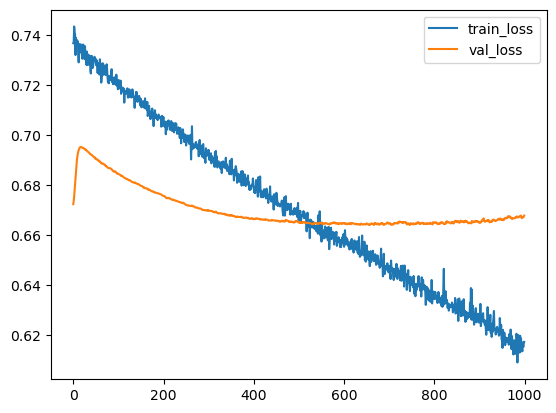

In [11]:
_ = log.plot()

In [12]:
with open('model.pkl', 'wb') as handle:
    pickle.dump(model, handle)

In [13]:
with open('model.pkl', 'rb') as handle:
    model = pickle.load(handle)

model.predict(x_test)

array([[ 0.50014883,  0.10510378,  0.01969483, ...,  0.11308742,
         1.2044077 , -0.41716525],
       [ 0.49471873,  0.18706493,  0.14862399, ...,  0.41446003,
         0.7608608 , -0.09827662],
       [ 0.519982  ,  0.47397372,  0.48825747, ...,  0.8489151 ,
        -0.06097475,  0.4052659 ],
       ...,
       [ 0.00366402, -0.39170772,  0.1251907 , ...,  1.0432467 ,
        -0.49449098,  0.30166447],
       [-0.13681161, -0.67245996, -0.42931092, ...,  0.0393784 ,
         0.6006927 , -1.0516708 ],
       [ 0.59722733,  0.7635591 ,  0.417351  , ...,  0.44667286,
         0.20434314, -0.14853637]], dtype=float32)

In [14]:
torch.cuda.is_available()

True

#### Quantus

In [15]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
)

In [16]:
model.device

device(type='cuda')

In [17]:
torch.tensor(x_train)

tensor([[ 1.1696e+00,  4.5708e-02, -1.5287e+00,  ...,  1.0000e+00,
          1.0000e+00,  0.0000e+00],
        [-4.4899e-01,  7.3367e+00,  5.3544e-03,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [ 3.6029e-01, -3.9101e-01, -1.5287e+00,  ...,  0.0000e+00,
          1.0000e+00,  1.0000e+00],
        ...,
        [ 1.9844e-01, -4.3408e-01, -2.5032e-01,  ...,  0.0000e+00,
          1.0000e+00,  1.0000e+00],
        [-1.2583e+00,  1.8797e+00,  5.3544e-03,  ...,  0.0000e+00,
          1.0000e+00,  1.0000e+00],
        [-8.5363e-01, -3.4093e-01,  6.0192e-01,  ...,  0.0000e+00,
          1.0000e+00,  1.0000e+00]])

In [18]:
model.eval()
# baseline_dist = torch.zeros(191, 11, requires_grad=True) * 0.001
inputs = torch.tensor(x_train, requires_grad=True).cuda() #.unsqueeze(dim=0)
outputs = torch.tensor(y_train[1].astype('int64')).cuda() #, requires_grad=True)
dl = DeepLift(model.net)
ig = IntegratedGradients(model.net)
baselines = torch.mean(inputs, dim=0).unsqueeze(dim=0).expand(inputs.shape)
attributions = []
for idx in range(num_durations):
    attributions.append(ig.attribute(inputs, target=torch.tensor(idx).cuda(), baselines=baselines)) #  baseline_dist, target=outputs,
# print('Mean Convergence Delta:', delta.mean().detach().numpy())

In [19]:
attributions = torch.stack(attributions)

In [20]:
print(attributions[:, 3, :].shape)

torch.Size([285, 11])


In [22]:
mean_attributions = torch.mean(attributions, dim=[0, 1])
mean_attributions = mean_attributions.detach()
mean_attributions = mean_attributions.cpu()
mean_attributions = list(mean_attributions.numpy())
print('Integrated Gradients mean attributions:', mean_attributions)


Integrated Gradients mean attributions: [0.00018503156313364266, -0.0030028529623957485, 0.0007914880423373166, -0.0023784007724424114, 0.005833313873160484, 0.007517594067707468, 0.0019844284308959776, 0.009068739355417717, 0.002087332802244741, 0.0023482835942150258, 0.003323042822472038]


In [29]:
import quantus

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# y_test = labtrans.transform(durations_test, events_test)
inputs_np, outputs_np = x_train, y_train[1].astype(np.int64)

metric = quantus.AvgSensitivity(nr_samples=10,
                                lower_bound=0.2,
                                norm_numerator=quantus.norm_func.fro_norm,
                                norm_denominator=quantus.norm_func.fro_norm,
                                perturb_func=quantus.perturb_func.uniform_noise,
                                similarity_func=quantus.similarity_func.difference
                                )
scores = metric(
    model=model.net,
    x_batch=inputs_np,
    y_batch=outputs_np,
    a_batch=attributions[0, ::].squeeze().detach().cpu().numpy(),
    device=device,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "IntegratedGradients"}
)

Warnings and information:
 (1) The Avg Sensitivity metric is likely to be sensitive to the choice of amount of noise added 'lower_bound' and 'upper_bound', the number of samples iterated over 'nr_samples', the function to perturb the input 'perturb_func', the similarity metric 'similarity_func' as well as norm calculations on the numerator and denominator of the sensitivity equation i.e., 'norm_numerator' and 'norm_denominator'.  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Yeh, Chih-Kuan, et al. 'On the (in) fidelity and sensitivity for explanations.' arXiv preprint arXiv:1901.09392 (2019).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the met

C:\Users\StanislawFrejlak\anaconda3\Lib\site-packages\quantus\helpers\warn.py:262: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


In [30]:
print(f"{np.max(scores):.3f}, {np.min(scores):.3f}, {np.mean(scores):.3f}, {np.std(scores):.3f}")

3.319, 0.079, 0.590, 0.557


In [26]:
metric2 = quantus.FaithfulnessCorrelation(subset_size=5,
                                similarity_func=(lambda a, b: quantus.similarity_func.difference(np.array(a), np.array(b))),
                                perturb_func=quantus.perturb_func.uniform_noise)

scores2 = metric2(
    model=model.net,
    x_batch=inputs_np,
    y_batch=outputs_np,
    a_batch=attributions[0, ::].squeeze().detach().cpu().numpy(),
    device=device,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "IntegratedGradients"}
)

Warnings and information:
 (1) The Faithfulness Correlation metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', size of subset |S| 'subset_size' and the number of runs (for each input and explanation pair) 'nr_runs'.  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Bhatt, Umang, Adrian Weller, and José MF Moura. 'Evaluating and aggregating feature-based model explanations.' arXiv preprint arXiv:2005.00631 (2020).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



C:\Users\StanislawFrejlak\anaconda3\Lib\site-packages\quantus\helpers\warn.py:262: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


In [31]:
print(scores2)

[0.015054331821831968]


#### Preparing data and non-deep models

In [ ]:
real_data = pd.read_csv("data/exp3_heart_failure_dataset.csv")
real_data.rename(columns={"DEATH_EVENT": "event"}, inplace=True)

In [ ]:
from sksurv.util import Surv
X = real_data[["age", "creatinine_phosphokinase", "ejection_fraction", "platelets",
                "serum_creatinine", "serum_sodium", "sex", "smoking"]]
y = Surv.from_dataframe("event", "time", real_data)

In [ ]:
from sksurv.ensemble import RandomSurvivalForest
rsf = RandomSurvivalForest(random_state=42, n_estimators=120, max_depth=8, min_samples_leaf=4, max_features=3)
rsf.fit(X, y)
rsf.score(X, y)

#### Creating explanations

In [ ]:
from survshap import SurvivalModelExplainer, ModelSurvSHAP
from survlime import SurvLIME
rsf_exp = SurvivalModelExplainer(rsf, X, y)

In [ ]:
exp3_survshap_global_rsf = ModelSurvSHAP(random_state=42)
exp3_survshap_global_rsf.fit(rsf_exp)

In [ ]:
with open("pickles/exp3_survshap_global_rsf", "wb") as f:
    pickle.dump(exp3_survshap_global_rsf, f)

In [ ]:
n_obs = len(X)
sls = [None for i in range(n_obs)]
funcs_dist = [None for i in range(n_obs)]
for i in tqdm(range(n_obs)):
    survlime = SurvLIME(N=1000)
    survlime.fit(rsf_exp, X.iloc[[i]], k=2, timestamps=rsf.predict_survival_function(X.iloc[[0]])[0].x)
    sls[i] = survlime

In [ ]:
with open("pickles/exp3_survlime_global_rsf", "wb") as f:
    pickle.dump(sls, f)

#### Results analysis

In [ ]:
with open("pickles/exp3_survshap_global_rsf", "rb") as f:
    exp3_survshap_global_rsf = pickle.load(f)

In [ ]:
with open("pickles/exp3_survlime_global_rsf", "rb") as f:
    exp3_survlime_global_rsf = pickle.load(f)

##### Plot examples

In [ ]:
example_rsf = exp3_survshap_global_rsf.individual_explanations[12]

In [ ]:
melted_example_rsf = pd.melt(example_rsf.result, id_vars="variable_name", value_vars=example_rsf.result.columns[6:])
melted_example_rsf["variable"] = melted_example_rsf["variable"].str[4:].astype(float)
melted_example_rsf.to_csv("results/exp3_example_rsf.csv", index=False)
example_rsf.simplified_result.to_csv("results/exp3_example_rsf_agg.csv", index=False)

In [ ]:
example_rsf2 = exp3_survshap_global_rsf.individual_explanations[14]
melted_example_rsf_2 = pd.melt(example_rsf2.result, id_vars="variable_name", value_vars=example_rsf2.result.columns[6:])
melted_example_rsf_2["variable"] = melted_example_rsf_2["variable"].str[4:].astype(float)
melted_example_rsf_2.to_csv("results/exp3_example_rsf_2.csv", index=False)

##### Importance rankings

In [ ]:
def get_orderings_and_ranks_shap(explanations):
    importance_orderings = []
    importance_ranks = []
    for explanation in explanations:
        df = explanation.result.copy()
        df["aggregated_change"] = trapezoid(np.abs(df.iloc[:, 6:].values), explanation.timestamps)
        importance_orderings.append(df.sort_values(by="aggregated_change", key=lambda x: -abs(x)).index.to_list())
        importance_ranks.append(np.abs(df.aggregated_change).rank(ascending=False).to_list())
    return pd.DataFrame(importance_orderings), pd.DataFrame(importance_ranks)

from scipy.stats import weightedtau
def mean_weighted_tau(ranks1, ranks2):
    taus = [None] * 100
    for i in range(100):
        tau, _ = weightedtau(ranks1.iloc[i], ranks2.iloc[i])
        taus[i] = tau
    return np.mean(taus), np.std(taus)

def prepare_ranking_summary_long(ordering):
    res = pd.DataFrame(columns=[0, 1, 2, 3, 4, 5, 6, 7])
    for i in range(8):
        tmp = pd.DataFrame(ordering[i].value_counts().to_dict(), index=[i+1])
        res = pd.concat([res, tmp])
    res = res.reset_index().rename(columns=dict(zip([i for i in range(8)] + ["index"], X.columns.to_list() + ["importance_ranking"])))
    return res.melt(id_vars=["importance_ranking"], value_vars=X.columns)

In [ ]:
def get_orderings_and_ranks_shap(explanations):
    importance_orderings = []
    importance_ranks = []
    for explanation in explanations:
        df = explanation.result.copy()
        df["aggregated_change"] = trapezoid(np.abs(df.iloc[:, 6:].values), explanation.timestamps)
        importance_orderings.append(df.sort_values(by="aggregated_change", key=lambda x: -abs(x)).index.to_list())
        importance_ranks.append(np.abs(df.aggregated_change).rank(ascending=False).to_list())
    return pd.DataFrame(importance_orderings), pd.DataFrame(importance_ranks)

def get_orderings_and_ranks_lime(explanations):
    importance_orderings = []
    importance_ranks = []
    for explanation in explanations:
        df = explanation.result
        df["impact"] = df["variable_value"] * df["coefficient"]
        importance_orderings.append(df.sort_values(by="impact", key=lambda x: -abs(x)).index.to_list())
        importance_ranks.append(np.abs(df.impact).rank(ascending=False).to_list())
    return pd.DataFrame(importance_orderings), pd.DataFrame(importance_ranks)

In [ ]:
rsf_survshap_orderings, rsf_survshap_ranks = get_orderings_and_ranks_shap(exp3_survshap_global_rsf.individual_explanations)
prepare_ranking_summary_long(rsf_survshap_orderings).to_csv("results/exp3_survshap_orderings_rsf.csv")

#### Calculating permutational variable importance

In [ ]:
from sksurv.metrics import brier_score, integrated_brier_score
# mask created to enable for calculating Brier score
mask = (y["time"] < y[y["event"]==1]["time"].max()) & (y["time"] > y[y["event"]==1]["time"].min())
times = np.unique(np.percentile(y[mask]["time"], np.linspace(0.1, 99.9, 101)))

np.unique(np.percentile(y[mask]["time"], np.linspace(0.1, 99.9, 101)))
def loss_integrated_brier_score(model, data, y):
    sfs = model.predict_survival_function(data)
    sfs = [sf(times) for sf in sfs]
    result = integrated_brier_score(y, y, sfs, times)
    return 1-result

In [ ]:
from sklearn.inspection import permutation_importance
imp_mean_rsf = permutation_importance(rsf, X, y,
                    scoring = loss_integrated_brier_score, n_repeats=100, random_state=42)["importances_mean"]

In [ ]:
pd.DataFrame(zip(X.columns, imp_mean_rsf)).sort_values(by=1, ascending=False)

In [ ]:
rsf_survlime_orderings, rsf_survlime_ranks = get_orderings_and_ranks_lime(exp3_survlime_global_rsf)

In [ ]:
prepare_ranking_summary_long(rsf_survlime_orderings).to_csv("results/exp3_survlime_orderings_rsf.csv")

#### Explaining deep model's predictions

We got the following results:

Integrated Gradients mean attributions: [ 0.0292784   0.02505408 -0.03815171  0.01266383  0.01597387  0.06627826
 -0.03912117 -0.02868438  0.06274574  0.03201562  0.00618445]

DeepLift mean attributions: [ 0.02618182  0.01984281 -0.03617777  0.0109012   0.01511144  0.06467749
 -0.03416074 -0.02320135  0.05641534  0.03421191  0.00955333]

#### Comparison of different explaining methods

In [ ]:
X.columns

In [ ]:
df_train.columns

In [ ]:
ig_results = [
    0.0292784,
    0.02505408,
    0.03815171,
    0.01266383,
    0.01597387,
    0.06627826,
    -0.03912117,
    0.02868438,
    0.06274574,
    0.03201562,
    0.00618445
]

deep_lift_results = [
    0.02618182,
    0.01984281,
    -0.03617777,
    0.0109012,
    0.01511144,
    0.06467749,
    -0.03416074,
    -0.02320135,
    0.05641534,
    0.03421191,
    0.00955333,
]

In [ ]:
len(df_train.columns)

In [ ]:
df_train.columns

In [ ]:
deep_df = pd.DataFrame({"feature": df_train.columns[:11], "ig": ig_results, "deep_lift": deep_lift_results})

In [ ]:
deep_df = deep_df[deep_df["feature"].isin(X.columns)]

In [ ]:
deep_df.sort_values(by="ig", ascending=False)

In [ ]:
pd.DataFrame(zip(X.columns, imp_mean_rsf)).sort_values(by=1, ascending=False)

In [ ]:
shap_df = pd.DataFrame(zip(X.columns, imp_mean_rsf)).sort_values(by=1, ascending=False)

In [ ]:
deep_shap_exp = SurvivalModelExplainer(rsf, df_train[:11], df_train[11:])
imp_mean_deep_shap = permutation_importance(model, df_train[:11], df_train[11:], 
                    scoring = loss_integrated_brier_score, n_repeats=100, random_state=42)["importances_mean"]

In [ ]:
deep_df.to_csv("project/deep_df_exp.csv")

In [ ]:
shap_df.to_csv("project/shap_exp.csv")